# Quantum error correction

## Historical background

Error correction has been a well developed field in classical computer science for decades. Classical error correction codes have been used by NASA since its Voyager missions [1] but they also undern modern communication technologies such as 4G.

In classical information processing, the use of error correction is most important for high-performance communication and high-security applications. Quantum information on the other hand is inherently more fragile than its classical counterpart, which makes error correction indispensible for any large scale application of quantum computing such as Shor's algorithm.

It is important to realize that, as will become clear in this exercise, quantum error correction is also qualitatively different from classical error correction because the set of errors that can occur are continous. In fact, for a long time it was not known if quntum error correction is possible at all but in 1995, Shor released another landmark paper: a scheme that shared quantum information over multiple qubits in order to reduce errors.[2]

A great deal of progress has been made over the decades since. New forms of quantum error correcting codes have been discovered, and a large theoretical framework has been built around them. The surface codes proposed by Kitaev in 1997 have emerged as the leading candidate, and many variations on the original design have emerged since then. But there is still a lot of progress to make in tailoring codes to the specific details of quantum hardware.[3]

In this exercise we'll consider a case in which artificial 'errors' are inserted into a circuit. Your task is to design the circuit such that these additional gates can be identified.

You'll then need to think about how to implement your circuit on a real device. This means you'll need to tailor your solution to the layout of the qubits. Your solution will be scored on how few entangling gates (the noisiest type of gate) that you use.

### Reference
1. https://descanso.jpl.nasa.gov/DPSummary/Descanso4--Voyager_new.pdf
2. Shor, Peter W. "Scheme for reducing decoherence in quantum computer memory." Physical review A 52.4 (1995): R2493.
3. Dennis, Eric, et al. "Topological quantum memory." Journal of Mathematical Physics 43.9 (2002): 4452-4505.

## The problem of errors

Errors occur when some spurious operation acts on our qubits. Their effects cause things to go wrong in our circuits. The strange results you may have seen when running on real devices is all due to these errors.

### The classical repitition code

Let's start by considering a bit of classical information `b`. Since a classical bit can only be `0` or `1`, the only kind of error that can occur is that the bit flips with propability $p$. 
$$
0 \to 
\begin{cases}
0~\text{with propability}~(1-p) \\
1~\text{with propability}~p
\end{cases}
$$
The simplest way to do classical error correction is what we all do intuitively: if your friend does not understand what you said at a bar, you repeat it; this is called the *repitition code*. Formally it means that we *encode* the two possible values `0` and `1` into *codewords*
$$
\bar 0 = 000\\
\bar 1 = 111
$$
The resulting bit $\bar b$ is called a *logical bit*. Now, if a single error occurs on out logical bit, we can correct it by what is called *majority voting*: we just reset the state of $\bar b$ to either $\bar 0$ or $\bar 1$ if there are more 0s or 1s in $\bar b$ respectively. 

### How about the quantum version?

How does quantum error correction differ from its classical counterpart? The main difference stems from the difference between classical and quantum information. A qubit is a state $|\psi \rangle = \alpha |0\rangle + \beta |1\rangle$ that, as you well know is parametrized by three continuous parameters. This also mean that the most general *error* that can occur on a single qubit is given by a hermitian $2\times 2$ matrix 
$$
M = a I + b X + c XZ + d Z,
$$
From the above decomposition, we can see that compared to the classical case we do not only get bitflip errors $X$ but also *phase-flip* errors $Z$ (or both, that is $XZ = -iY$).

Whenever we apply this matrix to some single qubit state $|\psi\rangle$ we get

$$
M |\psi\rangle = a|\psi\rangle + b X |\psi\rangle + c XZ |\psi\rangle + d Z |\psi\rangle.
$$

The resulting superposition is composed of the original state, the state we'd have if the error was just a bit flip, the state for just a phase flip and the state for both. This situation seems much more complicated than than the classical version! 
What makes quantum error correction a feasible task is that we can __measure__. If we devise a way to measure whether a bit or phase flip happened, the state collapses to one of the possbilities
$$
M |\psi\rangle \to
\begin{cases}
\phantom{XZ}|\psi\rangle &\text{with propability}~|a|^2 \\
\phantom{Z}X|\psi\rangle &\text{with propability}~|b|^2 \\
XZ|\psi\rangle &\text{with propability}~|c|^2 \\
\phantom{X}Z|\psi\rangle &\text{with propability}~|d|^2
\end{cases}
$$
and we can correct the quantum error deterministically. 

It runs our we can devise such measurement schemes and these are what we call quantum error correction codes. In this exercise we will try to get an intution about how this works. Most of the exercise whill be concerened with implementing a working *bit-flip* code on a quantum computer, but as you will (hopefully) see in the very end, the generalization to both phase- and bit-flips is not that hard!


# An overly simple example: Error detection

One of the first quantum circuits that most people ever write is to create a pair of entangled qubits, the Bell state. We will use this state to also gain some intutition about how to detect errors.

### State preparation

$\color{red}{\text{Exercise 1: Prepare a Bell state}}$

If your circuit is correct, running the cell below should yield the results `00` and `11` occurring with equal probability.

In [1]:
from qiskit import *
from qiskit import QuantumCircuit, Aer
import numpy as np

# Make an entangled pair
qr_bell = QuantumRegister(2, 'data')
qc_init = QuantumCircuit(qr_bell)



## YOUR CODE GOES HERE ##
qc_init.h(0)
qc_init.cx(0,1)



# Draw the circuit
display(qc_init.draw())

# Get an output
qc = qc_init.copy()  # deep copy the circuit qc_init
qc.measure_all()  # measure all qubits in the z-basis
job = Aer.get_backend('qasm_simulator').run(qc)  # run the circuit on a simulator and collect histogram of outcomes
job.result().get_counts()  # show histogram

┌───┐     
data_0: ┤ H ├──■──
        └───┘┌─┴─┐
data_1: ─────┤ X ├
             └───┘

{'11': 514, '00': 510}

### Error detection 1: measuring the final state
But what happens when we have the same circuit, but with an error?

$\color{red}{\text{Exercise 2: Insert different errors. Check the outcome. Which errors cannot be detected?}}$

In [5]:
# Make bit flip error
qc_insert = QuantumCircuit(2)



## INSERT DIFFERENT ERROR HERE ##
qc_insert.x(0)



# Add it to our original circuit
qc = qc_init.copy()
qc.barrier()
qc = qc.compose(qc_insert)

# Draw the circuit
display(qc.draw())

# Get an output
qc.measure_all()
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

┌───┐      ░ ┌───┐
data_0: ┤ H ├──■───░─┤ X ├
        └───┘┌─┴─┐ ░ └───┘
data_1: ─────┤ X ├─░──────
             └───┘ ░

{'01': 508, '10': 516}

You'll find that the output will change if you introduce a bit-flip error `x(0)` or `x(1)`, but not if we introduce a phase `z(0)` or `z(1)`. This is expected because what we have implemented so far is basically a *classical* error detection code! Before we move on to how to detect also phase flips however, let us first solve another problem: How to detect bit flips without destroying the prepared state!

#### Error detection 2: Parity Measurements
Note that we can view the Bell state $|\Psi_+> = \frac{1}{\sqrt 2}\left(|00\rangle+|11\rangle\right)$ as the encoded state of a single qubit state $|+\rangle=\frac{1}{\sqrt 2}\left(|0\rangle+|1\rangle\right)$. The above measurement in this language then detects a bit-flip error on the the state $|+\rangle$, but at the cost of destroying the state!
The solution to this is to instead of measuring the qubits itself measure only their *parity*, that is the operator $Z_0Z_1$

$\color{red}{\text{Exercise 3: Measure the parity of the Bell state.}}$

Hint: most of the code is already provided, you only need to add the necessary gates to qc_parity. You have only to construct the second part of the code below. With circuit.compose, you can add this circuit at the end to your solution of Exercise 1:


![title](Part3.png)

If your circuit is correct, the cell below yield the result `0` with propability 1.

In [6]:
# init circuit
qc_parity = QuantumCircuit(2) 

# Hint, you need to use one auxilary qubit!
qr_aux = QuantumRegister(1, 'aux')
cr_par = ClassicalRegister(1, 'parity')
qc_parity.add_register(qr_aux)
qc_parity.add_register(cr_par)



## YOUR CODE GOES HERE ##
## It should make qc_parity a circuit that measures the parity of the two qubits in the register cr_par
## Note that you do not need to prepare the bell state since qc_parity is composed with qc_init form exercise 1 below
qc_parity.cx(0, qr_aux[0])
qc_parity.cx(1, qr_aux[0])
qc_parity.measure(qr_aux[0], cr_par[0])


# compose init and parity measurement
qc = qc_init.copy()
qc.add_register(qr_aux) # dont forget to add the registers so that composition works
qc.add_register(cr_par)
qc.barrier()
qc = qc.compose(qc_parity)

display(qc.draw())

# Get an output
# qc = qc_parity.copy()
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

┌───┐      ░              
  data_0: ┤ H ├──■───░───■──────────
          └───┘┌─┴─┐ ░   │          
  data_1: ─────┤ X ├─░───┼────■─────
               └───┘ ░ ┌─┴─┐┌─┴─┐┌─┐
     aux: ───────────░─┤ X ├┤ X ├┤M├
                     ░ └───┘└───┘└╥┘
parity: 1/════════════════════════╩═
                                  0

{'0': 1024}

$\color{red}{\text{Exercise 4: As before, insert different errors. Which errrors can be detected now?}}$

Hint: The cell below already provides a working example, you just have to edit the line below ```# INSERT DIFFERENT ERRORS HERE``` to insert a different operator than $X$ on qubit 0.

In [7]:
# Define an error
qc_insert = QuantumCircuit(2)
qc_insert.add_register(qr_aux) # dont forget to add the registers so that composition works
qc_insert.add_register(cr_par)


# INSERT DIFFERENT ERRORS HERE
qc_insert.x(0) 



# Add this after the error
qc = qc_init.copy()
qc.add_register(qr_aux) # dont forget to add the registers so that composition works
qc.add_register(cr_par)
qc.barrier()
qc = qc.compose(qc_insert)
qc.barrier()
qc = qc.compose(qc_parity)

# Draw the circuit
display(qc.draw())

# Get an output
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

┌───┐      ░ ┌───┐ ░              
  data_0: ┤ H ├──■───░─┤ X ├─░───■──────────
          └───┘┌─┴─┐ ░ └───┘ ░   │          
  data_1: ─────┤ X ├─░───────░───┼────■─────
               └───┘ ░       ░ ┌─┴─┐┌─┴─┐┌─┐
     aux: ───────────░───────░─┤ X ├┤ X ├┤M├
                     ░       ░ └───┘└───┘└╥┘
parity: 1/════════════════════════════════╩═
                                          0

{'1': 1024}

Again, we can detect bit-flip but no phase flip errors. Note however, that in the circuit above, we do not measure any of the data qubits! In fact, the bell state is an eigenstate of parity $Z_0 Z_1$, which means that if we do measure `1`, we can use the state on the data qubits and be sure that no bit-flip error occurred with respect to the initial state.

Before we move on to detect also phase flips, we have one more problem to solve for the bit-flip errors: the above circuit tells us if a bitflip happened, but it doesnt tell us where! If we only new where the bitflip occured, we could even actively apply a *recovery* operation to restore the original state! It turns out, we only need to use one more data-qubit to achieve this!

# The bit-flip repetition code on a quantum computer

In the next part, we go a step further. We now consider a 3-qubit code which uses parity checks to detect the presence and position of an X error. Although this is essentially a classical code, we still have to avoid some pitfalls if we want to implement it on a quantum computer!

### State preparation.. again
$\color{red}{\text{Exercise 5: Encode the state }~|\psi\rangle = \frac{1}{\sqrt{2}}(|0\rangle + i|1\rangle)~\text{into the 3-qubit code state of the repitition code}~|\bar\psi\rangle=\frac{1}{\sqrt{2}}(|000\rangle + i|111\rangle)~\text{to be protected from one bit-flip ( X ) error}}$

In [8]:
qr_3qx_data = QuantumRegister(3, 'data')
qc_3qx_init = QuantumCircuit(qr_3qx_data)




## YOUR CODE GOES HERE ##
# Hint: generalize your circuit from exercise 1!
qc_3qx_init.h(qr_3qx_data[0])
qc_3qx_init.p(np.pi/2, qr_3qx_data[0])
qc_3qx_init.cx(qr_3qx_data[0], qr_3qx_data[1])
qc_3qx_init.cx(qr_3qx_data[1], qr_3qx_data[2])



#######
qc_3qx_init.draw()

┌───┐┌────────┐          
data_0: ┤ H ├┤ P(π/2) ├──■───────
        └───┘└────────┘┌─┴─┐     
data_1: ───────────────┤ X ├──■──
                       └───┘┌─┴─┐
data_2: ────────────────────┤ X ├
                            └───┘

$\color{red}{\text{Exercise 6: Plot the 3-qubit code state produced by the above circuit, } {\tt qc\_3qx} \text{ on the qsphere to validate the encoding}}$

- Check the [method](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.html#qiskit.quantum_info.Statevector.from_instruction) which returns a statevector produced by a quantum circuit.
- Check [here](https://qiskit.org/documentation/tutorials/circuits/2_plotting_data_in_qiskit.html#Plot-State) to plot a quantum state on the qsphere.

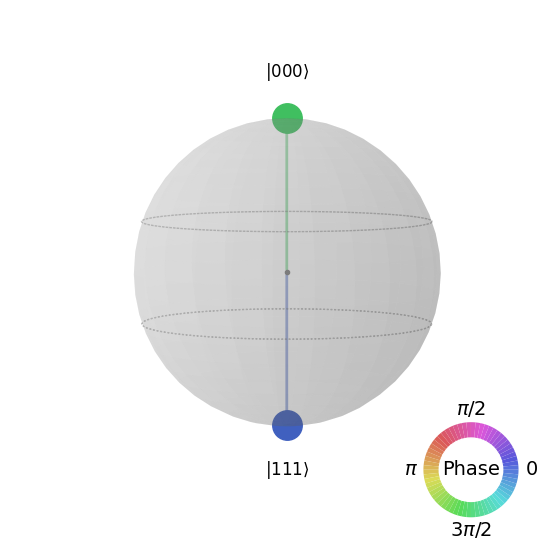

In [9]:
from qiskit.visualization import plot_state_qsphere
backend = BasicAer.get_backend('statevector_simulator') # the device to run on



## YOUR CODE GOES HERE ##
result = backend.run(transpile(qc_3qx_init, backend)).result()
psi  = result.get_statevector(qc_3qx_init)
plot_state_qsphere(psi)

### Parity Measurements.. again

$\color{red}{\text{Exercise 7: Implement a circuit that measures the two parity checks}~Z_0Z_1~\text{and}~Z_1Z_2}$


If your circuit is correct, the cell below yield the result `00` with probability 1.

In [10]:
## YOUR CODE GOES HERE ##

qc_3qx_parity = QuantumCircuit(qr_3qx_data) 
# Hint: you now need two ancillas and two classical measurement bits
qr_3qx_aux = QuantumRegister(2, 'measure')
cr_3qx_par = ClassicalRegister(2, 'parity')

qc_3qx_parity.add_register(qr_3qx_aux)
qc_3qx_parity.add_register(cr_3qx_par)

### your code goes here. ### 
qc_3qx_parity.cx(qr_3qx_data[0], qr_3qx_aux[0]) 
qc_3qx_parity.cx(qr_3qx_data[1], qr_3qx_aux[0])
qc_3qx_parity.cx(qr_3qx_data[1], qr_3qx_aux[1])
qc_3qx_parity.cx(qr_3qx_data[2], qr_3qx_aux[1])
qc_3qx_parity.measure(qr_3qx_aux[0], cr_3qx_par[0])
qc_3qx_parity.measure(qr_3qx_aux[1], cr_3qx_par[1])



# this draws the parity part only
display(qc_3qx_parity.draw())


# compose with state preparation 
qc = qc_3qx_init.copy()
qc.add_register(qr_3qx_aux) # dont forget to add registers for compose to work
qc.add_register(cr_3qx_par)
qc = qc.compose(qc_3qx_parity)
# Get an output
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

data_0: ──■───────────────────────
             │                       
   data_1: ──┼────■────■─────────────
             │    │    │             
   data_2: ──┼────┼────┼───────■─────
           ┌─┴─┐┌─┴─┐  │  ┌─┐  │     
measure_0: ┤ X ├┤ X ├──┼──┤M├──┼─────
           └───┘└───┘┌─┴─┐└╥┘┌─┴─┐┌─┐
measure_1: ──────────┤ X ├─╫─┤ X ├┤M├
                     └───┘ ║ └───┘└╥┘
 parity: 2/════════════════╩═══════╩═
                           0       1

{'00': 1024}

$\color{red}{\text{Exercise 8: Again, insert different errors and inspect the outcomes. How do we infer from the outcome of the two parity measurement where the bit-flip happened?}}$

In [11]:
# Define an error
qc_3qx_insert = QuantumCircuit(2)
qc_3qx_insert.add_register(qr_3qx_aux) # dont forget to add the registers so that composition works
qc_3qx_insert.add_register(cr_3qx_par)



## INSERT DIFFERENT ERRORS HERE ##
qc_3qx_insert.x(0)



# Add this after the error
qc = qc_3qx_init.copy()
qc.add_register(qr_3qx_aux) # dont forget to add the registers so that composition works
qc.add_register(cr_3qx_par)
qc = qc.compose(qc_3qx_insert)
qc = qc.compose(qc_3qx_parity)

# Draw the circuit
display(qc.draw())

# Get an output
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

┌───┐┌────────┐     ┌───┐                          
   data_0: ┤ H ├┤ P(π/2) ├──■──┤ X ├──■───────────────────────
           └───┘└────────┘┌─┴─┐└───┘  │                       
   data_1: ───────────────┤ X ├──■────┼────■────■─────────────
                          └───┘┌─┴─┐  │    │    │             
   data_2: ────────────────────┤ X ├──┼────┼────┼───────■─────
                               └───┘┌─┴─┐┌─┴─┐  │  ┌─┐  │     
measure_0: ─────────────────────────┤ X ├┤ X ├──┼──┤M├──┼─────
                                    └───┘└───┘┌─┴─┐└╥┘┌─┴─┐┌─┐
measure_1: ───────────────────────────────────┤ X ├─╫─┤ X ├┤M├
                                              └───┘ ║ └───┘└╥┘
 parity: 2/═════════════════════════════════════════╩═══════╩═
                                                    0       1

{'01': 1024}

### Correcting Bit-Flips

The following operation will apply a single bit flip error on the code. Execute the cells below.

In [12]:
def apply_err(n, err):
    
    qc = QuantumCircuit(int(n), name='Error')
    which_qubit = np.random.randint(n)
    
    if err=='bit':
        qc.x(which_qubit)
    elif err=='phase':
        qc.z(which_qubit)
    else:
        pass
    
    err_str = ['1' for _ in range(n)]
    err_str[which_qubit] = 'x' if err=='bit' else 'z'
    
    return qc.to_gate(), ''.join(err_str)

Apply the parity check gates on the circuit `qc` with the extra registers for the appropriate number of auxiliary qubits and syndrome bits to locate a bit-flip ( X ) error on a single qubit in the code. ( For 3 qubit code, the number of syndrome bit states is equal to the number of possible single bit-flip error, including no error.)

$\color{red}{\text{Exercise 9:  Complete the dictionary in the following cell to make the syndrome look-up table for all single bit-flip errors on the three qubit code.}}$
Hint: Watch out the order of the measurement output when using backend.run()

The key of the dictionary is a two-bit string denoting the outcome of the parity measurements (called the 'syndrome') and the values reprent the corresponding a single qubit error gates with the appropriate qubit indicies on the code circuit.

In [13]:
#### complete the dictionary ###

# table_syndrome_3qx = {'00': '111', '01':' your answer ', 
#                       '10':' your answer ', '11':'1x1'}

table_syndrome_3qx = {'00': '111', '01':'x11',   #Watch out the order, this is due to the convention of the IBM output
                      '10': '11x', '11':'1x1'}
######
print(table_syndrome_3qx)

{'00': '111', '01': 'x11', '10': '11x', '11': '1x1'}


If your dictionary is correct, the cell below should always print True!

In [14]:
# qc_3qx_trans = transpile(qc_3qx, sim)
# syndrome = sim.run(qc_3qx_trans, shots=1, memory=True).result().get_memory()
# print(syndrome)

# get random error
err, err_str = apply_err(3, 'bit')

# Add this after the error
qc = qc_3qx_init.copy()
qc = qc.compose(err)
qc.add_register(qr_3qx_aux) # dont forget to add the registers so that composition works
qc.add_register(cr_3qx_par)
qc = qc.compose(qc_3qx_parity)

# Draw the circuit
display(qc.draw())


# Get an output
sim = Aer.get_backend('aer_simulator')
qc_trans = transpile(qc, sim)
syndrome = sim.run(qc_trans, shots=1, memory=True).result().get_memory()[0]

print(table_syndrome_3qx[syndrome] == err_str)

┌───┐┌────────┐          ┌────────┐                          
   data_0: ┤ H ├┤ P(π/2) ├──■───────┤0       ├──■───────────────────────
           └───┘└────────┘┌─┴─┐     │        │  │                       
   data_1: ───────────────┤ X ├──■──┤1 Error ├──┼────■────■─────────────
                          └───┘┌─┴─┐│        │  │    │    │             
   data_2: ────────────────────┤ X ├┤2       ├──┼────┼────┼───────■─────
                               └───┘└────────┘┌─┴─┐┌─┴─┐  │  ┌─┐  │     
measure_0: ───────────────────────────────────┤ X ├┤ X ├──┼──┤M├──┼─────
                                              └───┘└───┘┌─┴─┐└╥┘┌─┴─┐┌─┐
measure_1: ─────────────────────────────────────────────┤ X ├─╫─┤ X ├┤M├
                                                        └───┘ ║ └───┘└╥┘
 parity: 2/═══════════════════════════════════════════════════╩═══════╩═
                                                              0       1

True


We are now able to sucessfully detect any bit (single) bit flip on our logical qubit and we can use this information to apply a recovery operation. 
$\color{red}{\text{Convince yourself that even though we do not learn the logical state of the data qubit, we can use the syndrome information to construct a recovery that corrects the bitflip error!}}$

# What about phase-flips?

Now that we can recover from bit-flips, lets consider how we can adapt the procedure above to detect phase-flips instead of bit-flips. It turns out that this is almost trivial since we can convert an bitflip `x` error to a `z` error by conjugating it with hadamard gates! 
$$
HXH = Z
$$ 

$\color{red}{\text{Exercise 10: Implement the three-qubit phase-flip code!}}$
1. Implement a new encoding circuit `qc_3qz_init`
2. Implement a new parity measurement circuit `qc_3qz_parity`
3. Implement a new lookup table `table_syndrome_3qz`

In [15]:
### YOUR CODE GOES HERE ###

# HINT: For both, state preparation and parity checks, you can simply copy the circuits of the bit-flip code and add three additional Hadamard gates!

qr_3qz_data = QuantumRegister(3, 'data')
qc_3qz_init = QuantumCircuit(qr_3qz_data)

# state preparation
qc_3qz_init = qc_3qx_init.copy()
qc_3qz_init.h(0)
qc_3qz_init.h(1)
qc_3qz_init.h(2)

display(qc_3qz_init.draw())


# parity measurement
qc_3qz_parity = QuantumCircuit(qr_3qz_data) 
qr_3qz_aux = QuantumRegister(2, 'measure')
cr_3qz_par = ClassicalRegister(2, 'parity')
qc_3qz_parity.add_register(qr_3qz_aux)
qc_3qz_parity.add_register(cr_3qz_par)

qc_3qz_parity.h(0)
qc_3qz_parity.h(1)
qc_3qz_parity.h(2)
qc_3qz_parity = qc_3qz_parity.compose(qc_3qx_parity)

display(qc_3qz_parity.draw())

table_syndrome_3qz = {'00': '111', '01':'z11',   #Watch out the order, this is due to the convention of the IBM output
                      '10': '11z', '11':'1z1'}

┌───┐┌────────┐     ┌───┐     
data_0: ┤ H ├┤ P(π/2) ├──■──┤ H ├─────
        └───┘└────────┘┌─┴─┐└───┘┌───┐
data_1: ───────────────┤ X ├──■──┤ H ├
                       └───┘┌─┴─┐├───┤
data_2: ────────────────────┤ X ├┤ H ├
                            └───┘└───┘

┌───┐                          
   data_0: ┤ H ├──■───────────────────────
           ├───┤  │                       
   data_1: ┤ H ├──┼────■────■─────────────
           ├───┤  │    │    │             
   data_2: ┤ H ├──┼────┼────┼───────■─────
           └───┘┌─┴─┐┌─┴─┐  │  ┌─┐  │     
measure_0: ─────┤ X ├┤ X ├──┼──┤M├──┼─────
                └───┘└───┘┌─┴─┐└╥┘┌─┴─┐┌─┐
measure_1: ───────────────┤ X ├─╫─┤ X ├┤M├
                          └───┘ ║ └───┘└╥┘
 parity: 2/═════════════════════╩═══════╩═
                                0       1

if you implementation of the phase flip code is correct, the cell below should always evaluate to True!

In [16]:
# get random error
err, err_str = apply_err(3, 'phase')

# Add this after the error
qc = qc_3qz_init.copy()
qc = qc.compose(err)
qc.add_register(qr_3qz_aux) # dont forget to add the registers so that composition works
qc.add_register(cr_3qz_par)
qc = qc.compose(qc_3qz_parity)

# Draw the circuit
display(qc.draw())

# Get an output
sim = Aer.get_backend('aer_simulator')
qc_trans = transpile(qc, sim)
syndrome = sim.run(qc_trans, shots=1, memory=True).result().get_memory()[0]

# print(syndrome, err_str)

print(table_syndrome_3qz[syndrome] == err_str)

┌───┐┌────────┐     ┌───┐     ┌────────┐┌───┐                       »
   data_0: ┤ H ├┤ P(π/2) ├──■──┤ H ├─────┤0       ├┤ H ├──■────────────────────»
           └───┘└────────┘┌─┴─┐└───┘┌───┐│        │├───┤  │                    »
   data_1: ───────────────┤ X ├──■──┤ H ├┤1 Error ├┤ H ├──┼────■────■──────────»
                          └───┘┌─┴─┐├───┤│        │├───┤  │    │    │          »
   data_2: ────────────────────┤ X ├┤ H ├┤2       ├┤ H ├──┼────┼────┼───────■──»
                               └───┘└───┘└────────┘└───┘┌─┴─┐┌─┴─┐  │  ┌─┐  │  »
measure_0: ─────────────────────────────────────────────┤ X ├┤ X ├──┼──┤M├──┼──»
                                                        └───┘└───┘┌─┴─┐└╥┘┌─┴─┐»
measure_1: ───────────────────────────────────────────────────────┤ X ├─╫─┤ X ├»
                                                                  └───┘ ║ └───┘»
 parity: 2/═════════════════════════════════════════════════════════════╩══════»
                                                                        0      »
«              
«   data_0: ───
«              
«   data_1: ───
«              
«   data_2: ───
«              
«measure_0: ───
«           ┌─┐
«measure_1: ┤M├
«           └╥┘
« parity: 2/═╩═
«            1

True


# A full-fledged quantum-error-correction code
We now know how to detect and correct bit-flips and phase-flips independently. However this is not enough on a real device, where both errors can happen, even simultaneously!

The easiest solution to this problem --  and the one proposed in Shor's original paper [2] -- is what is called *code concatenation*, that is we implement for example a phase-flip code, but with each qubit substituted by a bit-flip code!

$\color{red}{\text{Exercise 11: Convince yourself that this works in principle :)}}$

Shor's 9-qubit code is not very practically, both in that it requires measuring six-body parities and in that it uses nine qubit, although one can correct a single bit and phase-flip simultaneously using only [5 code qubits](https://en.wikipedia.org/wiki/Five-qubit_error_correcting_code)! 

$\color{red}{\text{If you like: Implement the 5-qubit code)}}$

These notebooks are comprised of text and code taken from Qiskit's [documentation](https://qiskit.org/documentation/), [tutorials](https://qiskit.org/documentation/tutorials.html#quantum-circuits), [textbook](https://qiskit.org/textbook/preface.html), and previous challenges facilitated by Qiskit.